In [44]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy
import PIL
import os
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization
import os

# Local imports
import sys
sys.path.append('../../../')
import stlstuff as sls
import imagestuff as ims
import statstuff as sts

In [45]:
%matplotlib notebook

In [46]:
# Graphics parameters
fontsize = 10
linewidth = 2
matplotlib.rcParams.update({'font.size': fontsize})

In [47]:
# Set defaults for the analysis
numforhist = 55
accumlist = [11,12,13,14,15] # This will get filled in as the entire set of segments unless overridden below
eta_visual = .95
rminforhist = 1e-7
rmaxforhist = .6

In [48]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd()
print(pwd)
startpos = pwd.find('crystals/')
case = pwd[startpos+9:]; print(case)

/Users/nesh/Documents/Repositories/ice4/crystals/2016-06-30_ice1/case1.2.1
2016-06-30_ice1/case1.2.1


In [49]:
pwd[2]

's'

In [50]:
whos

Variable                       Type            Data/Info
--------------------------------------------------------
Axes3D                         type            <class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>
Compressedfilename             str             retrieved.npz
Filename                       str             SEMimages/2016-06-30_ice1_rough2_10degrees-D.bmp
IwantURT                       bool            True
Iwantlog                       bool            True
Iwantroughness                 bool            True
Iwanttosave                    bool            True
PIL                            module          <module 'PIL' from '/User<...>ackages/PIL/__init__.py'>
Rotxp                          matrix          [[ 0.99217458 -0.        <...> 0.          0.99217458]]
Roty                           matrix          [[ 1.         -0.        <...>-0.02251276  0.99974656]]
Rotzpp                         matrix          [[ 0.99999605 -0.00281162<...>-0.          1.        ]]
Roughnessdatafile

In [51]:
# Derivative names
Compressedfilename = 'retrieved.npz'; print (Compressedfilename)
Roughnessfile = 'roughness.jpg'; print(Roughnessfile)
Roughnessdatafile ='roughness.txt'; print(Roughnessdatafile)

retrieved.npz
roughness.jpg
roughness.txt


In [52]:
# Get the retrieved surface
npzfile = np.load(Compressedfilename)
imageroot = '2016-06-30_ice1_rough2_10degrees'
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot)
print("dx and dy", dx, dy)

dx and dy 0.7322417 0.7322417


In [53]:
nx1list = npzfile['nx1list']
nx2list = npzfile['nx2list']
ny1list = npzfile['ny1list']
ny2list = npzfile['ny2list']
pA = npzfile['pA']
pB = npzfile['pB']
pC = npzfile['pC']
pD = npzfile['pD']
sA = npzfile['sA']
sB = npzfile['sB']
sC = npzfile['sC']
sD = npzfile['sD']
nxi = npzfile['nxi']
nyi = npzfile['nyi']
dnx = npzfile['dnx']
dny = npzfile['dny']
solution = npzfile['solution']
nsegments = len(nx1list)
if len(accumlist)==0:
    accumlist = [i for i in range(nsegments)]
    
print('Completed',case) #Prints loading but I wanted to know when it was done.

Completed 2016-06-30_ice1/case1.2.1


In [54]:
Iwantroughness = True
Iwanttosave = True
Iwantlog = True
IwantURT = True

<IPython.core.display.Javascript object>


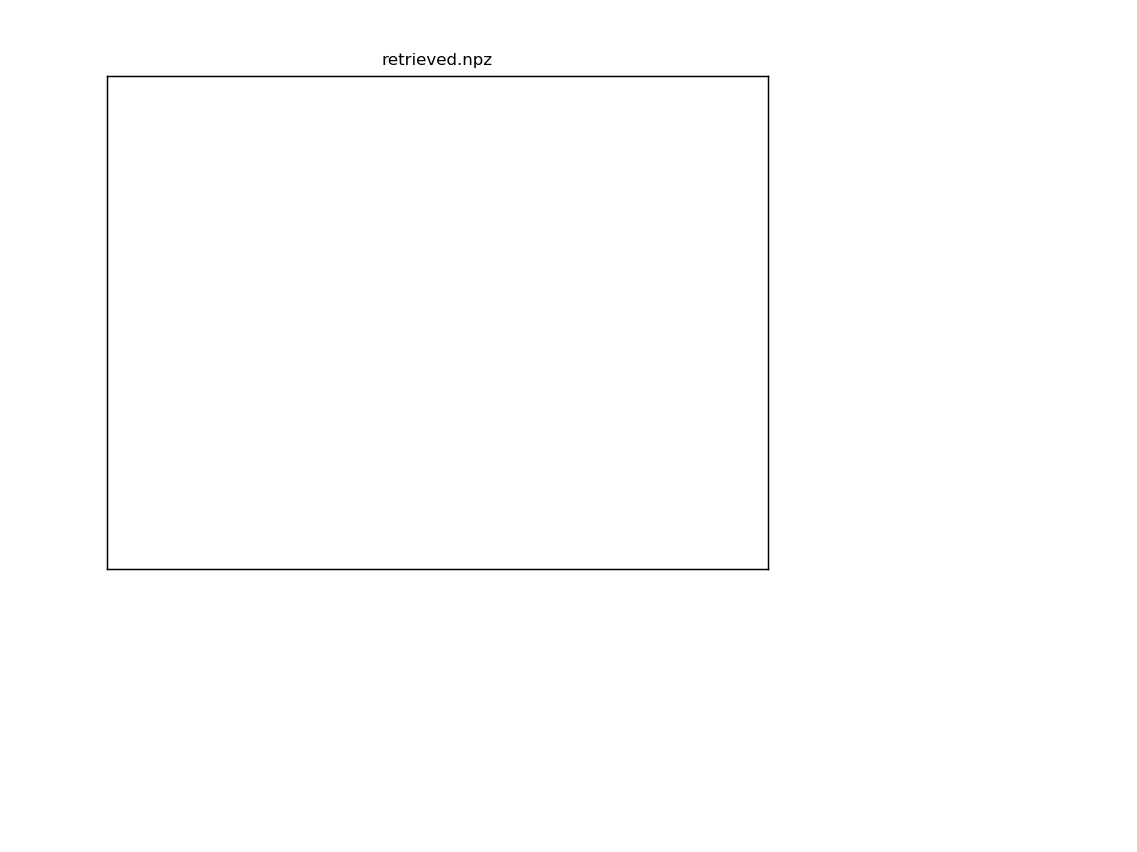

In [55]:
# Graph the segments
im = PIL.Image.open(Filename)
ny_im,nx_im = np.shape(im)
draw = PIL.ImageDraw.Draw(im)
fig, ax = plt.subplots()
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),2)
ax.set_title(Compressedfilename,fontsize=fontsize*0.9)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

plt.show(im,cmap = 'Greys_r', vmin = 0,vmax = 255)
im.show() # This shouldn't be necessary but there seems to be a bug with plt.show

In [56]:
# Setting up null arrays
hbins_accum = []
meanrsub_accum = []
zsigma_accum = []
Z2_accum = []
Zsquared_accum = []
rsub_accum = []
meanrsublist = []
Zsigmalist = []
Z2list = []

# And a graphics parameter
stride = 1

In [57]:
# Now, to evaluate the roughness ... First step is to flatten each panel via rotation
# Here we explicitly flip the y-coordinate (to make it a right-handed system) so we don't have to invert on the fly
if Iwantroughness:
    
    for isegment in range(0,nsegments):
    #for isegment in range(15,16):

        # Extract this segment
        nx1=nx1list[isegment]; nx2=nx2list[isegment]; nxsegment = nx2-nx1+1
        ny1=ny1list[isegment]; ny2=ny2list[isegment]; nysegment = ny2-ny1+1
        surf_xseg = np.linspace(0,(nxsegment-1)*dx,nxsegment); 
        surf_yseg = np.linspace(0,(nysegment-1)*dy,nysegment); 
        surf_xseggrid, surf_yseggrid = np.meshgrid(surf_xseg,surf_yseg) # 1st index is y, 2nd is x
        surf_zseggrid = copy.copy(np.flipud(solution[ny1:ny2+1,nx1:nx2+1])) # This flips the y-coordinate

        # Fit a plane to the data and adjust data to start at the origin
        m = ims.polyfit2d(\
                      surf_xseggrid.reshape(nysegment*nxsegment), \
                      surf_yseggrid.reshape(nysegment*nxsegment), \
                      surf_zseggrid.reshape(nysegment*nxsegment), \
                      linear=True,order=1)
        
        # Get the angles of the plane
        dzdy = m[1]; thetay = np.arctan(dzdy)*180/np.pi; #print 'y:', thetay

        # Get rotation matrix & flatten in one direction
        Roty = ims.myrotation_matrix([1,0,0], -thetay)
        surf_xseggridp, surf_yseggridp, surf_zseggridp = \
            ims.flatten(surf_xseggrid, surf_yseggrid, surf_zseggrid, Roty)

        # Fit a plane to the data and adjust data to start at the origin
        mp = ims.polyfit2d(\
                      surf_xseggridp.reshape(nysegment*nxsegment), \
                      surf_yseggridp.reshape(nysegment*nxsegment), \
                      surf_zseggridp.reshape(nysegment*nxsegment), \
                      linear=True,order=1)
        
        # Get the angle of the plane in another direction
        dzdx = mp[2]; thetaxp = np.arctan(dzdx)*180/np.pi; #print 'x:', thetaxp

        # Get rotation matrix & flatten in another direction
        Rotxp = ims.myrotation_matrix([0,1,0], thetaxp)
        surf_xseggridpp, surf_yseggridpp, surf_zseggridpp = \
            ims.flatten(surf_xseggridp, surf_yseggridp, surf_zseggridp, Rotxp)

            
        # Trying out the polyval2d
        surf_zseggrid_theory_long = ims.polyval2d(\
                      surf_xseggrid.reshape(nysegment*nxsegment), \
                      surf_yseggrid.reshape(nysegment*nxsegment), \
                      m)
        surf_zseggrid_theory = surf_zseggrid_theory_long.reshape(nysegment,nxsegment)
        #surf_zseggrid_theory -= z0
        surf_xseggridp_theory, surf_yseggridp_theory, surf_zseggridp_theory = \
            ims.flatten(surf_xseggrid, surf_yseggrid, surf_zseggrid_theory, Roty)
        surf_xseggridpp_theory, surf_yseggridpp_theory, surf_zseggridpp_theory = \
            ims.flatten(surf_xseggridp_theory, surf_yseggridp_theory, surf_zseggridp_theory, Rotxp)

        # Now rotate
        deltay = surf_yseggridpp_theory[0,-1]-surf_yseggridpp_theory[0,0]
        deltax = surf_xseggridpp_theory[0,-1]-surf_xseggridpp_theory[0,0]
        thetazpp = -np.arctan(deltay/deltax)*180/np.pi;
        Rotzpp = ims.myrotation_matrix([0,0,1], thetazpp)
        surf_xseggridppp, surf_yseggridppp, surf_zseggridppp = \
            ims.flatten(surf_xseggridpp, surf_yseggridpp, surf_zseggridpp, Rotzpp)
        surf_xseggridppp_theory, surf_yseggridppp_theory, surf_zseggridppp_theory = \
            ims.flatten(surf_xseggridpp_theory, surf_yseggridpp_theory, surf_zseggridpp_theory, Rotzpp)

        # Now we have to extract an orthogonal subset
        dxsub = dysub = dx
        xsubstart = np.max(surf_xseggridppp_theory[[0,-1],0])+dxsub*2
        xsubstop = np.min(surf_xseggridppp_theory[[0,-1],-1])-dxsub*2
        ysubstart = np.max(surf_yseggridppp_theory[0,[0,-1]])+dysub*2
        ysubstop = np.min(surf_yseggridppp_theory[-1,[0,-1]])-dysub*2
        xsub = np.arange(xsubstart,xsubstop,dxsub)
        ysub = np.arange(ysubstart,ysubstop,dysub)
        sub_xseggrid, sub_yseggrid = np.meshgrid(xsub,ysub) # 1st index is y, 2nd is x
        nsuby, nsubx = np.shape(sub_xseggrid)
        surf_xseggridppp_theory_long = np.reshape(surf_xseggridppp_theory,nysegment*nxsegment)
        surf_yseggridppp_theory_long = np.reshape(surf_yseggridppp_theory,nysegment*nxsegment)
        points = np.vstack((surf_xseggridppp_theory_long,surf_yseggridppp_theory_long)).T # rows are x,y pairs
        values = np.reshape(surf_zseggridppp,nysegment*nxsegment)
        sub_zseggrid_long = griddata(points, values, (sub_xseggrid, sub_yseggrid), method='cubic')
        sub_zseggrid = np.reshape(sub_zseggrid_long,(nsuby, nsubx))
        
        # Now we get the roughness
        dzsub_dx = np.diff(sub_zseggrid,axis=1)/np.diff(sub_xseggrid,axis=1)
        dzsub_dy = np.diff(sub_zseggrid,axis=0)/np.diff(sub_yseggrid,axis=0)
        Zsquared = dzsub_dx[1:,:]**2+dzsub_dy[:,1:]**2
        rsub = 1.0 - 1/np.sqrt(1+Zsquared)
        mu = 1-rsub
        phi = np.arccos(mu)
        Zplus = Zsquared**.5
        Z = np.hstack((Zplus,-Zplus)) # Need +/- to generate a two-sided distribution
        thismeanrsub = np.round(np.mean(rsub)*1000)/1000; meanrsublist.append(thismeanrsub)
        thissigma = np.round(np.std(Z)*100)/100; Zsigmalist.append(thissigma)
        thismeanZ2 = np.mean(Zsquared); Z2list.append(thismeanZ2)
        
        # Plotting surfaces
        title1 = 'panel_' +list(map(str,[isegment+1]))[0]#"TypeError: 'map' object is not subscriptable" stackoverflow said added the list() so the map is indexable
        
        # Numerical distribution functions
        rsub_long = np.reshape(rsub,np.size(rsub))
        
        # This needs to be changed to adjust for log spacing
        newrbins=np.geomspace(rminforhist,rmaxforhist,num=numforhist)
        hist = np.histogram(rsub_long,bins=newrbins)
        
        rbins = hist[1][0:-1]
        rbins1 = hist[1][1:]
        hbins = hist[0] 
        norm = -np.trapz(rbins,hbins)
        hbins = hbins/norm
        
        # Defining the analytical distribution function bins
        rwidth = rbins1-rbins
        rbinsW = (rbins+rwidth/2.0)        
                
        # Accumulate the binned data
        if isegment in accumlist:
            hbins_accum.append(hbins)
            meanrsub_accum.append(thismeanrsub)
            zsigma_accum.append(thissigma)
            Z2_accum.append(thismeanZ2)
            
            Zsquared_long = np.reshape(Zsquared,np.size(Zsquared))
            Zsquared_accum = np.append(Zsquared_accum,Zsquared_long)
            
            rsub_long = np.reshape(rsub,np.size(rsub))
            rsub_accum = np.append(rsub_accum,rsub_long)
            
            print('Accumulating ...', np.shape(Zsquared), np.shape(Zsquared_long), np.shape(Zsquared_accum))
            

print(newrbins)
for isegment in range(len(meanrsublist)):
    print('segment, #pts, <r>, sigma =', \
        isegment, np.size(rsub), meanrsublist[isegment], Zsigmalist[isegment])

../../../imagestuff.py:204: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, _, _, _ = np.linalg.lstsq(G, z)


Accumulating ... (26, 35) (910,) (910,)
Accumulating ... (26, 35) (910,) (1820,)
Accumulating ... (26, 35) (910,) (2730,)
Accumulating ... (26, 35) (910,) (3640,)
Accumulating ... (26, 36) (936,) (4576,)
[1.00000000e-07 1.33512313e-07 1.78255377e-07 2.37992877e-07
 3.17749794e-07 4.24235099e-07 5.66406093e-07 7.56221875e-07
 1.00964932e-06 1.34800615e-06 1.79975419e-06 2.40289345e-06
 3.20815862e-06 4.28328678e-06 5.71871525e-06 7.63518900e-06
 1.01939174e-05 1.36101349e-05 1.81712059e-05 2.42607973e-05
 3.23911516e-05 4.32461757e-05 5.77389694e-05 7.70886335e-05
 1.02922818e-04 1.37414634e-04 1.83465456e-04 2.44948974e-04
 3.27037041e-04 4.36634717e-04 5.82961110e-04 7.78324861e-04
 1.03915952e-03 1.38740592e-03 1.85235773e-03 2.47312564e-03
 3.30192725e-03 4.40847944e-03 5.88586286e-03 7.85835164e-03
 1.04918670e-02 1.40079343e-02 1.87023171e-02 2.49698962e-02
 3.33378859e-02 4.45101825e-02 5.94265742e-02 7.93417937e-02
 1.05931064e-01 1.41431013e-01 1.88827817e-01 2.52108386e-01
 3.

41.05715532573016


<IPython.core.display.Javascript object>


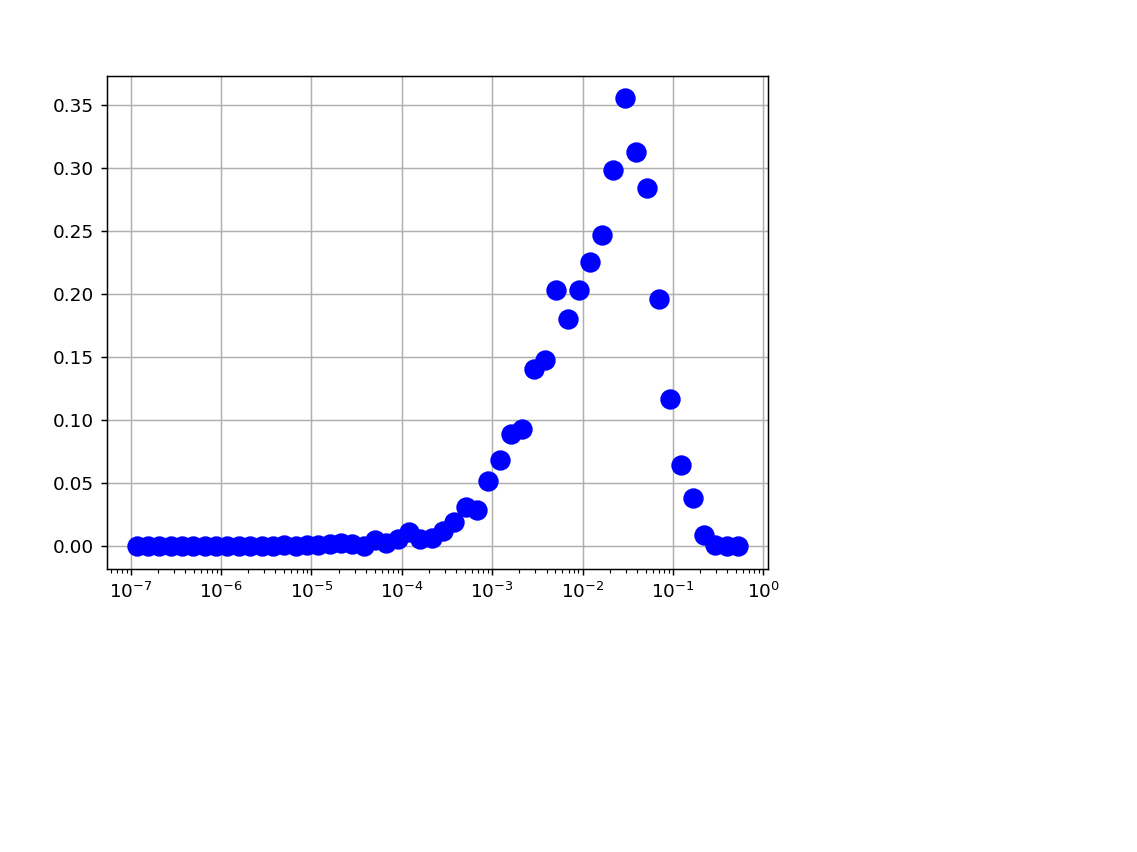

In [58]:
# This graphs observed results

# Calculate the observed histogram
hbins_total = np.sum((hbins_accum),axis=0)/len(accumlist)

# Normalize
norm = -np.trapz(np.log(rbinsW),hbins_total); print(norm)
hbins_total = hbins_total/norm

# Graph it
plt.figure()
plt.semilogx(rbinsW,hbins_total,'ob',markersize=10, label='obs')
plt.grid(True)

In [59]:
# Get the best match sigma and eta
x0 = np.array([0.1,1.0])
solution, solutionerror = optimization.curve_fit(sts.pWeibullr, rbinsW, hbins_total, x0)
best_sigma = solution[0]; 
print('Weibull: best_sigma = ', best_sigma)
best_eta = solution[1]
print('Weibull: best_eta = ', best_eta)

# Get the best match for a two-gaussian fit
x0 = np.array([0.1,0.1,.5])
solution, solutionerror = optimization.curve_fit(sts.bimodalfunc, rbinsW, hbins_total, x0)
best_sigma1 = solution[0]
best_N1 = 1-solution[2]
print('Bimodal: best_sigma1,N1 = ', best_sigma1,best_N1)
best_sigma2 = solution[1]
best_N2 = solution[2]
print('Bimodal: best_sigma2,N2 = ', best_sigma2,best_N2)

Weibull: best_sigma =  0.234943481819257
Weibull: best_eta =  0.8150870444594722
Bimodal: best_sigma1,N1 =  0.25843347793134847 0.8327511164635226
Bimodal: best_sigma2,N2 =  0.08457265999683865 0.16724888353647738


In [60]:
# Get the best-fit distributions
hbins_bestfit = sts.pWeibullr(rbinsW, best_sigma, best_eta)
print('R^2 (Weibull) = ',sts.R_squar(hbins_total,hbins_bestfit))
hbins_gauss = sts.pWeibullr(rbinsW, best_sigma, 1)
print('R^2 (Gauss) = ',sts.R_squar(hbins_total,hbins_gauss))
hbins_bimodal = sts.bimodalfunc(rbinsW, best_sigma1, best_sigma2, best_N2)
print('R^2 (Gauss) = ',sts.R_squar(hbins_total,hbins_bimodal))


R^2 (Weibull) =  0.9813344374333627
R^2 (Gauss) =  0.9348820138412175
R^2 (Gauss) =  0.9899800317483256


<IPython.core.display.Javascript object>


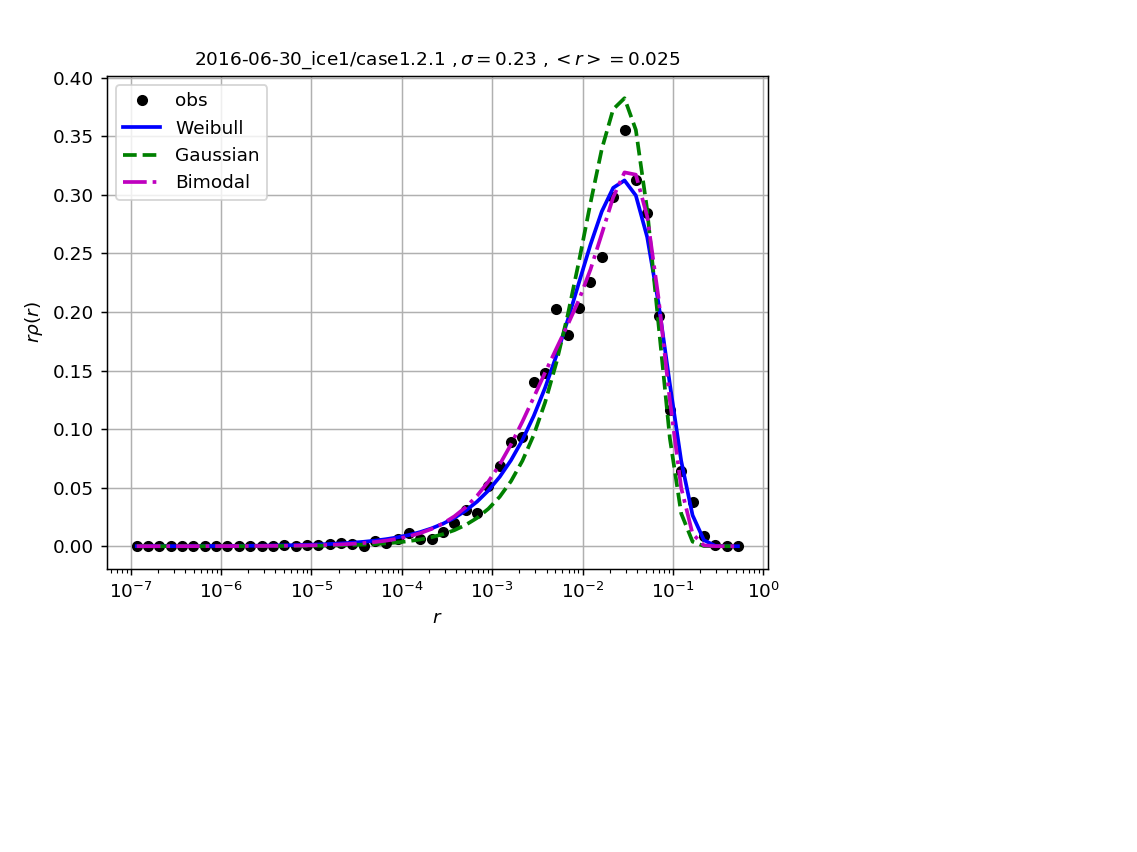

Text(0.5,1,'2016-06-30_ice1/case1.2.1 $,\\sigma=$0.23 $,<r>=$0.025')

In [67]:
# Graph
plt.figure()
plt.semilogx(rbinsW,hbins_total,'ok',markersize=5, label='obs')
plt.semilogx(rbinsW,hbins_bestfit,'-b',linewidth=2, label='Weibull')
plt.semilogx(rbinsW,hbins_gauss,'--g',linewidth=2, label='Gaussian')
plt.semilogx(rbinsW,hbins_bimodal,'-.m',linewidth=2, label='Bimodal')
plt.grid(True)
plt.xlabel(r'$r$',fontsize=fontsize)
plt.ylabel(r'$r\rho(r)$',fontsize=fontsize)
plt.legend(loc='upper left')
sigma_legend = np.round(best_sigma*100)/100
meanr_legend = np.round(sts.sigma2meanr(sigma_legend)*1000)/1000
title2 = r' $,\sigma=$'+list(map(str,[sigma_legend]))[0]+r' $,<r>=$'+list(map(str,[meanr_legend]))[0]
plt.title(case+title2,fontsize=fontsize)
#plt.tight_layout()


In [62]:
if Iwanttosave:
    plt.savefig(Roughnessfile)
    dummy= [rbinsW,hbins_total]
    np.savetxt(Roughnessdatafile,dummy)